In [1]:
#import bibliotek
import os
import sklearn
from skimage import io
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
import preprocessing as pre


In [2]:
#załadowanie zdjęć
directory = "images"

data = np.zeros((13804, 60, 60))
#data = np.zeros((1000, 60, 60))

for index, filename in enumerate(os.listdir(directory)):
        f = os.path.join(directory, filename)
        img = io.imread(f)
        
        if img.shape[2] < 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = pre.preprop_hachaj(img)
            img = pre.mass_mean(img)
            img = pre.rotate(img)
            data[index, :, :] = img
   

89.0


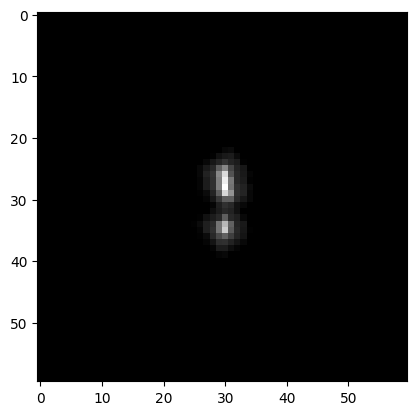

In [3]:
#przykladowy obraz
image = data[68]
plt.imshow(image, cmap="gray")
print(image.max())

In [4]:
#reshape danych pod cechy pca
data = data.reshape(13804, 3600)
#data = data.reshape(1000, 3600)

In [5]:
#skalowanie cech
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)

data = scaler.transform(data)

In [6]:
#dokonanie pca
#variancja większa niz 0.95 !!!
pca = PCA(n_components=60)
#pca = PCA(n_components=40)
pca.fit(data)
print(sum(pca.explained_variance_ratio_))


0.9571205899082701


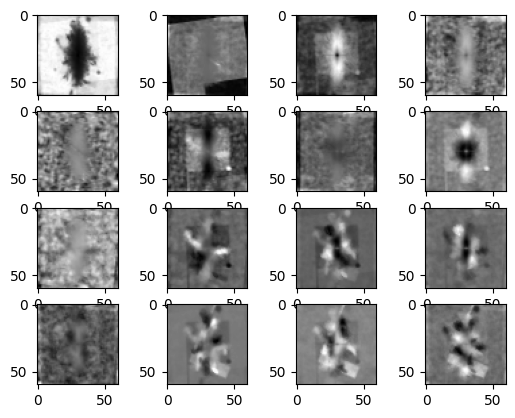

In [7]:
#wizualizacja cech
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pca.components_[i].reshape((60, 60)), cmap="gray")
    #plt.title(i)

0.23723101995354126
1.0298438416026994
(3600,)


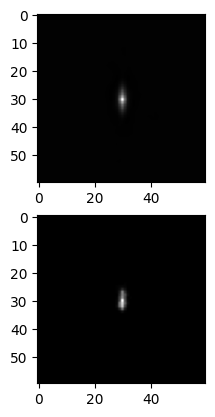

In [8]:
#odwtorzenie przykladowego zdjecia z algorytmu pca
liczba = 1
img = pca.transform(data[liczba].reshape((1, 3600)))

obraz = np.zeros(3600)

for index, item in enumerate(img[0]):
    obraz += item*pca.components_[index]

print(max(obraz))
print(max(data[liczba]))


print(obraz.shape)

obraz1 = np.array([obraz])
obraz2 = np.array([data[liczba]])

obraz1 = scaler.inverse_transform(obraz1).reshape((60, 60))
obraz2 = scaler.inverse_transform(obraz2).reshape((60, 60))

plt.subplot(2, 1, 1)

plt.imshow(obraz1, cmap="gray")

plt.subplot(2, 1, 2)
plt.imshow(obraz2, cmap="gray")

In [9]:
#srednia roznica obu obrazow
diff = abs(np.subtract(obraz1, obraz2))
sum_diff = sum(sum(diff))/len(diff)
print(sum_diff)

5.969205211733674


In [10]:
#zamiana wszystkich obrazow 

lista_f1 = []
lista_f2 = []

for i in range(13804):
    img = pca.transform(data[i].reshape((1, 3600)))
    obraz = np.zeros(3600)
    for index, item in enumerate(img[0]):
        obraz += item*pca.components_[index]

    obraz1 = scaler.inverse_transform(np.array([obraz])).reshape((60, 60))
    obraz2 = scaler.inverse_transform(np.array([data[i]])).reshape((60, 60))
    diff = abs(np.subtract(obraz1, obraz2))
    diff_2 = diff**2
    sum_diff = sum(sum(diff))/len(diff)
    sum_diff_2 = sum(sum(diff_2))/len(diff_2)
    lista_f1.append(sum_diff)
    lista_f2.append(sum_diff_2)
    

In [11]:
lista = np.zeros(13804)

dane = np.array([pca.transform(data[i].reshape((1, 3600))) for i in range(13804)])

dane = dane.reshape(13804, 60)
for index, i in enumerate(range(60)):
    var = np.var(dane[:, i])
    mean = np.mean(dane[:, i])
    for ind, j in enumerate(range(13804)):
        c= dane[j, i]
        lista[j] += abs((c-mean)/var)    

    

Text(0, 0.5, 'Z-score')

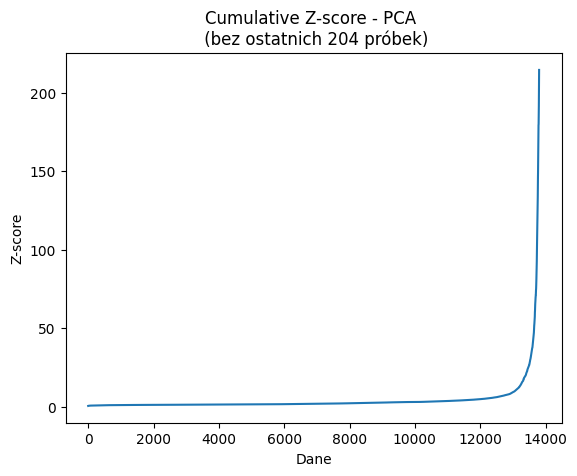

In [12]:
indexes = [x for _, x in sorted(zip(lista ,range(0, 13804)))]

plt.plot(sorted(lista))#)[:13600])
plt.title("Cumulative Z-score - PCA \n (bez ostatnich 204 próbek)")
plt.xlabel("Dane")
plt.ylabel("Z-score")

In [13]:
lista = np.array(lista_f1)

indexes = [x for _, x in sorted(zip(lista ,range(0, 13804)))]

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(kernel="linear")

y = np.array([0 for i in range(8000)]+[1])
x = np.array([pca.transform(data[i].reshape((1, 3600))) for i in indexes[:8000]]+[pca.transform(data[indexes[-1]].reshape((1, 3600)))], dtype=int)

x = x.reshape((8001, 60))

svm.fit(x, y)

SVC(kernel='linear')

In [15]:
acc = accuracy_score(y, svm.predict(x))
print(acc)

1.0


In [16]:
y_test = np.array([0 for i in range(13804)])
x_test = np.array([pca.transform(data[i].reshape((1, 3600))) for i in range(13804)])

x_test = x_test.reshape((13804, 60))

acc = accuracy_score(y_test, svm.predict(x_test))
print(acc)

0.9984062590553463


In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(kernel="linear")

num1 = 11000
num2 = 50

y = np.array([0 for i in range(num1)]+[1 for i in range(num2)])
x = np.array([pca.transform(data[i].reshape((1, 3600))) for i in indexes[:num1]]+[pca.transform(data[i].reshape((1, 3600))) for i in indexes[-num2-1:-1]], dtype=int)

x = x.reshape((num1+num2, 60))

svm.fit(x, y)

SVC(kernel='linear')

In [18]:
acc = accuracy_score(y, svm.predict(x))
print("Train: ", acc)

y_test = np.array([0 for i in range(13804)])
x_test = np.array([pca.transform(data[i].reshape((1, 3600))) for i in range(13804)])

x_test = x_test.reshape((13804, 60))

acc = accuracy_score(y_test, svm.predict(x_test))
print("Test: ", 1-acc)

Train:  1.0
Test:  0.014053897421037354


Text(0, 0.5, 'Ilość zliczeń')

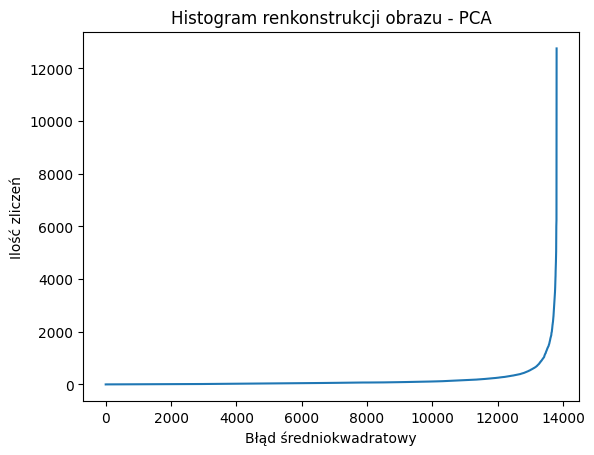

In [19]:
x = 50

#histogram pokazujący skutecznośc pca, czyli jak bardzo obraz pierwotny rozni sie od rozkladu
a, b = np.histogram(np.array(lista_f2), x, (0, x))

#plt.hist(lista_f2, 50, range=(0, 2000))
plt.plot(sorted(lista_f2))
plt.title("Histogram renkonstrukcji obrazu - PCA")
plt.xlabel("Błąd średniokwadratowy")
plt.ylabel("Ilość zliczeń")

In [36]:
indexes = [x for _, x in sorted(zip(lista_f2 ,range(0, 13804)))]

(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(60, 60)


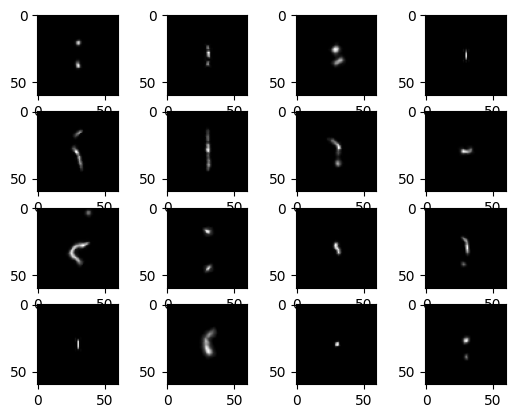

In [54]:


for i in range(16):
    plt.subplot(4, 4, 1+i)
    #pdata[indexes[1000+i]].reshape((60, 60)))
    dat = np.array([data[indexes[-1-500-i]]])
    obraz = scaler.inverse_transform(dat).reshape(60, 60)
    print(obraz.shape)
    plt.imshow(obraz, cmap = "gray")


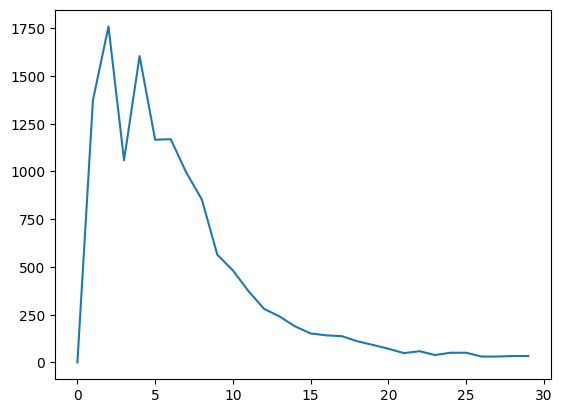

In [20]:
x = 30

#histogram pokazujący skutecznośc pca, czyli jak bardzo obraz pierwotny rozni sie od rozkladu
a, b = np.histogram(lista, x, (0, x))

plt.plot(a)

In [21]:
#proba klastrowania cech
from sklearn.cluster import DBSCAN

dane = pca.transform(data)

dbscan_opt=DBSCAN(eps=3,min_samples=20)
dbscan_opt.fit(dane)

DBSCAN(eps=3, min_samples=20)

In [22]:
labels = dbscan_opt.labels_
unique_labels = set(dbscan_opt.labels_)

print(len(unique_labels))
print(len(labels) - np.count_nonzero(labels))

2
12295


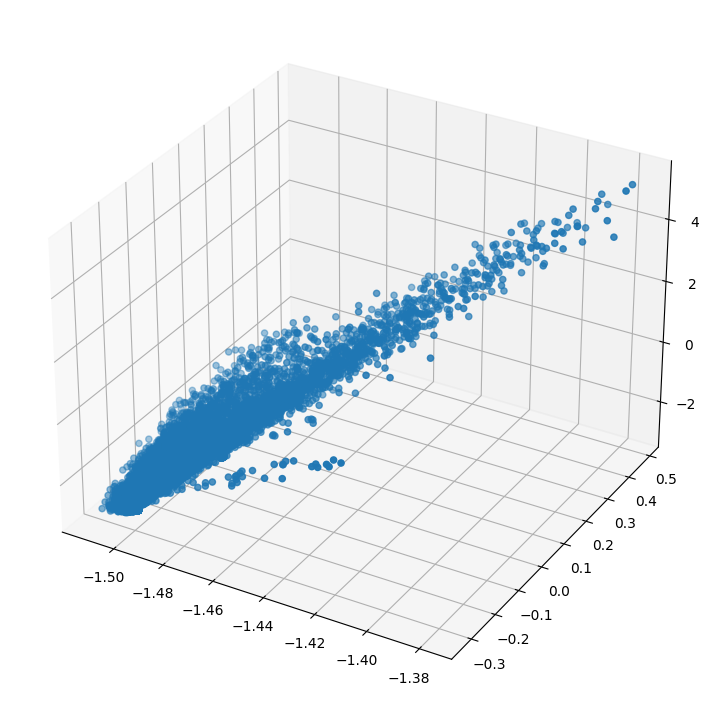

In [23]:
#wizualizacja graficzna stosunku pierwszych 3 cech dla zdjęć
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")


core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan_opt.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = dane[class_member_mask & core_samples_mask]
    ax.scatter3D(
        xy[:, 0],
        xy[:, 1],
        xy[:, 2]
        #color=tuple(col)
        
    )





In [24]:
lista_y = []
lista_x = []
for epsilon in range(5, 30):
    epsilon = epsilon/10
    dbscan_opt=DBSCAN(eps=epsilon,min_samples=20)
    dbscan_opt.fit(dane)
    labels = dbscan_opt.labels_
    
    #unique, counts = np.unique(labels, return_counts=True)
    #zliczenie = dict(zip(unique, counts))
    #print(zliczenie)

    outliers = np.where(labels == -1)[0]
    #print(len(outliers))

    #print(len(unique_labels))
    #print(len(labels) - np.count_nonzero(labels))
    lista_x.append(epsilon)
    lista_y.append(len(outliers))

Text(0, 0.5, 'Liczba outlierów')

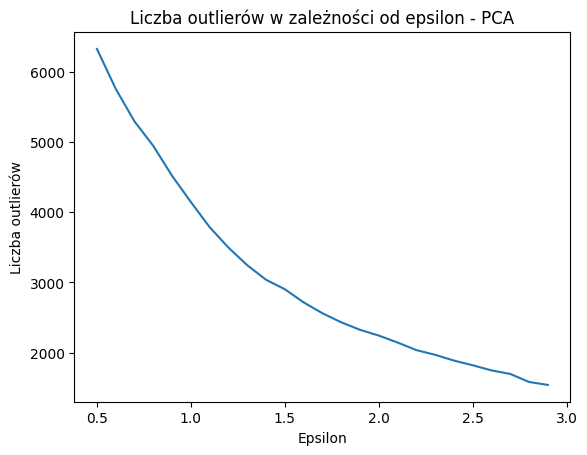

In [25]:
plt.plot(lista_x, lista_y)
plt.title("Liczba outlierów w zależności od epsilon - PCA")
plt.xlabel("Epsilon")
plt.ylabel("Liczba outlierów")